# Movie Rating Prediction Using Graph NN
by Sebouh Kafalian
email: od20skk@leeds.ac.uk

In this research, we aim to apply graph neural networks (GNNs) to predict movie ratings. By representing movies as graphs, where nodes correspond to movies, actors or countries and edges are weighted based on casting order, we propose to leverage the structural relationships within the cast order to predict a film’s rating. We hypothesize that the prominence of certain actors, as well as the overall graph structure of the cast, plays a significant role in a movie's success. Through this proposal, we outline the steps for preprocessing the data, constructing the graph representation, training the GNN model, and evaluating its predictive performance. Our goal is to demonstrate the potential of GNNs in movie rating prediction through graph-based actor and production country networks.

Download the files from [Netflix TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies)

#### Imports

We start by importing all the necessary libraries for our research, which provide functionalities for building and training our graph neural network model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from itertools import chain

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
from torch.nn import MSELoss, L1Loss
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
from torch_geometric.data import HeteroData

from recommendation_engine.proposal.notebook import tools
from recommendation_engine.proposal.notebook import models

torch.manual_seed(0);

/Users/kafalian/uni/recommendation_engine/proposal/notebook/tools.py:269: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if predictions_df is not None and title is not '':
/Users/kafalian/uni/recommendation_engine/proposal/notebook/tools.py:389: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if predictions_df is not None and title is not '':


We load the movie dataset and check the content.

In [2]:
movies_info_df = pd.read_csv('./data/archive/titles.csv')

movies_info_df = movies_info_df.rename(columns={'id':'movie_id'})
movies_info_df.sort_values('imdb_votes', ascending=False).head(10)
movies_info_df.head()

,movie_id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


We can see that we have the following columns
* movie_id: Unique identifier for each movie or show.
* title: The title of the movie or show.
* type: Indicates whether the entry is a movie or a show.
* description: A brief description or summary of the movie/show.
* release_year: The year the movie or show was released.
* age_certification: The age rating or certification (e.g., "PG", "R").
* runtime: Duration of the movie in minutes or show episode length.
* genres: List of genres associated with the movie/show.
* production_countries: Countries where the movie/show was produced.
* seasons: Number of seasons for TV shows (NaN for movies).
* imdb_id: The unique IMDb identifier for the movie/show.
* imdb_score: The IMDb rating score.
* imdb_votes: Number of votes or ratings on IMDb.
* tmdb_popularity: Popularity score from The Movie Database (TMDb).
* tmdb_score: TMDb rating score.

Now let's load the 'credits' data.

In [3]:
credits_df = pd.read_csv('./data/archive/credits.csv')
credits_df = credits_df.rename(columns={'id': 'movie_id'})
credits_df.head()

,person_id,movie_id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


Here we have relatively simple data 
* person_id: A unique identifier for each person (actor or director).
* movie_id: The unique identifier for the movie in which the person participated.
* name: The name of the actor or director.
* character: The name of the character played by the actor in the movie (NaN for directors).
* role: The role of the person in the movie "ACTOR" or "DIRECTOR".

As we mentioned above, in this research we are going to consider only movies and try to predict their associated IMDb scores. So, lets merge those 2 datasets and remove all redundant data. After which we want to check the imdb_votes distribution.

In [4]:
credits_df = credits_df.merge(movies_info_df, left_on='movie_id', right_on='movie_id')
credits_df = credits_df.dropna(subset=['imdb_score'])
credits_df = credits_df[credits_df['type'] == 'MOVIE']
credits_df = credits_df.drop(columns=['type', 'seasons', 'imdb_id'])
credits_df.movie_id = credits_df.movie_id.apply(lambda id_text: int(id_text[2:]))
credits_df.head()

,person_id,movie_id,name,character,role,title,description,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,3748,84618,Robert De Niro,Travis Bickle,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
1,14658,84618,Jodie Foster,Iris Steensma,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
2,7064,84618,Albert Brooks,Tom,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
3,3739,84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
4,48933,84618,Cybill Shepherd,Betsy,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179


Let's plot the KDE of IMDb votes. 

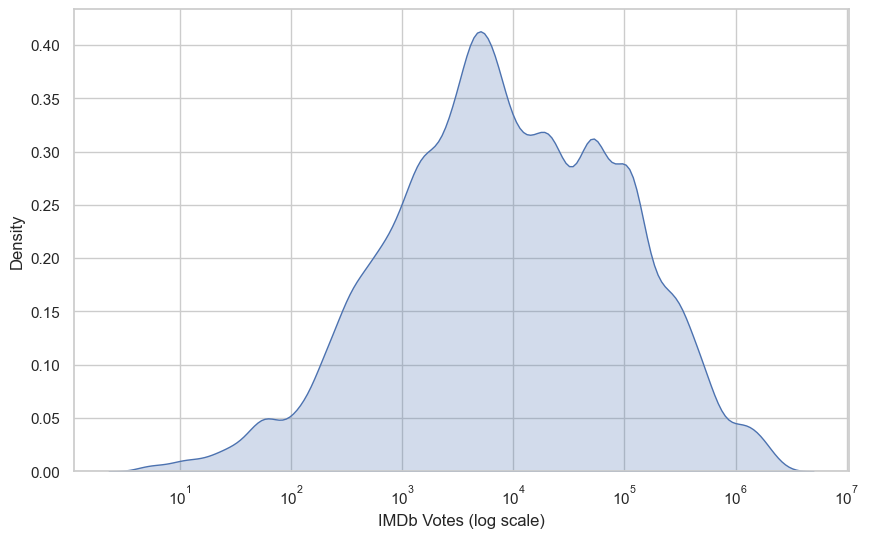

In [5]:
plt.figure(figsize=(10, 6))
sns.kdeplot(credits_df['imdb_votes'], log_scale=True, fill=True)
plt.xlabel('IMDb Votes (log scale)')
plt.ylabel('Density')
plt.show()

Now, let's clean the data by removing the movies that are not popular enough to get sufficient votes to accurately reflect their true rating.  

In [6]:
lower_bound = credits_df['imdb_votes'].quantile(0.2)
print(f"filter out movies with imdb votes less than {lower_bound}")
credits_filtered_df = credits_df[credits_df['imdb_votes'] > lower_bound]

filter out movies with imdb votes less than 1152.0


To simplify the graph creation we fiter out all uncredited actors and actors that have multiple acting roles in a given movie and only leave their first character.

In [7]:
duplicates = credits_filtered_df.duplicated(subset=['person_id', 'movie_id','role'], keep="first")
credits_filtered_df = credits_filtered_df[~duplicates]
print(f"Removed: {sum(duplicates)} multiple characters in a single movie")

Removed: 60 multiple characters in a single movie


Next, we check the distributions of person relations and movie relations.   

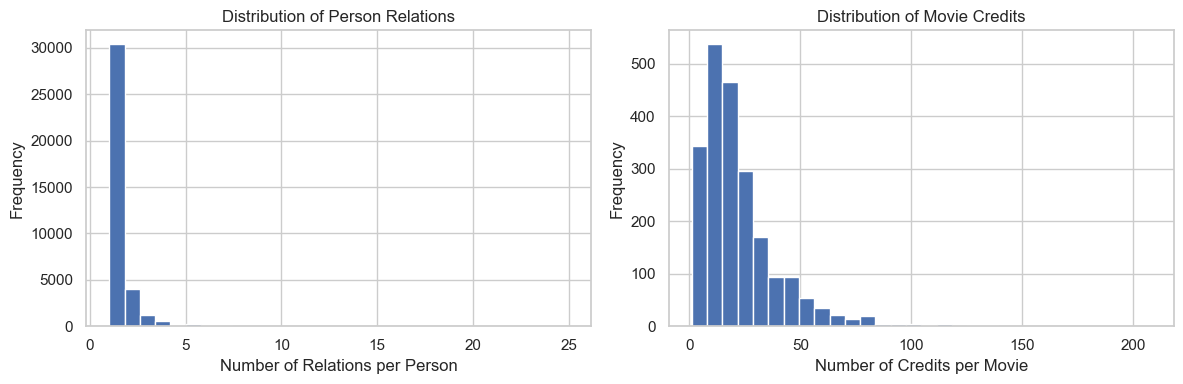

In [8]:
credits_count_by_person = credits_filtered_df.groupby(['person_id']).size()
credits_count_by_movie = credits_filtered_df.groupby(['movie_id']).size()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(credits_count_by_person, bins=30)
axs[0].set_title("Distribution of Person Relations")
axs[0].set_xlabel("Number of Relations per Person")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

axs[1].hist(credits_count_by_movie, bins=30)
axs[1].set_title("Distribution of Movie Credits")
axs[1].set_xlabel("Number of Credits per Movie")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Scale IMDb score
Let's scale the IMDb score using min max scaler.

In [9]:
rating_scaler = MinMaxScaler()

credits_filtered_df.insert(value=rating_scaler.fit_transform(credits_filtered_df[['imdb_score']]), column='label', loc=0)
credits_filtered_df = credits_filtered_df.reset_index(drop=True)
credits_filtered_df.head()

,label,person_id,movie_id,name,character,role,title,description,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,0.878378,3748,84618,Robert De Niro,Travis Bickle,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
1,0.878378,14658,84618,Jodie Foster,Iris Steensma,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
2,0.878378,7064,84618,Albert Brooks,Tom,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
3,0.878378,3739,84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
4,0.878378,48933,84618,Cybill Shepherd,Betsy,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179


In [10]:
movies_df = credits_filtered_df.drop_duplicates(subset=['movie_id']).reset_index(drop=True)

movies_df = movies_df.reset_index().set_index('movie_id')
movies_df = movies_df.drop(columns=['name', 'character', 'role','person_id', 'description'])
movies_df = movies_df.rename(columns={"index": "movie_idx"})
movies_df.head()

,movie_idx,label,title,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
movie_id,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
154986,1,0.810811,Deliverance,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
127384,2,0.878378,Monty Python and the Holy Grail,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811
120801,3,0.810811,The Dirty Dozen,1967,NaN,150,"['war', 'action']","['GB', 'US']",7.7,72662.0,20.398,7.600
70993,4,0.851351,Life of Brian,1979,R,94,['comedy'],['GB'],8.0,395024.0,17.770,7.800


#### Movie Age Certification

In [11]:
movies_df['age_certification'].value_counts()

age_certification
R        482
PG-13    363
PG       182
G         48
NC-17     13
Name: count, dtype: int64

Here is quick explanation of age certification in increasing order of restriction.
* G (General Audiences): Suitable for all ages. Contains no strong language, violence, or sexual content.
* PG (Parental Guidance Suggested): Some material may not be suitable for children, such as mild language or brief violence.
* PG-13 (Parents Strongly Cautioned): Some material may be inappropriate for children under 13. May include more intense violence or brief nudity.
* R (Restricted): Restricted to viewers over 17 years old unless accompanied by an adult. Typically, includes strong language, violence, or sexual content.
* NC-17 (No One 17 and Under Admitted): Explicit content unsuitable for children, usually due to strong sexual content or graphic violence.

Therefore, we can encode those values using label encoder and normalize to get value from 0 to 1.  

In [12]:
le = LabelEncoder()
le.fit(['G', 'PG', 'PG-13', 'R', 'NC-17'])
movies_df.insert(value = le.transform(movies_df.age_certification.fillna('PG-13')), column='age_certification_normalized', loc=3)
movies_df.age_certification_normalized = movies_df.age_certification_normalized / len(le.classes_)
movies_df = movies_df.drop(columns=['age_certification'])
movies_df.head()

,movie_idx,label,title,age_certification_normalized,release_year,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
movie_id,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.8,1976,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
154986,1,0.810811,Deliverance,0.8,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
127384,2,0.878378,Monty Python and the Holy Grail,0.4,1975,91,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811
120801,3,0.810811,The Dirty Dozen,0.6,1967,150,"['war', 'action']","['GB', 'US']",7.7,72662.0,20.398,7.600
70993,4,0.851351,Life of Brian,0.8,1979,94,['comedy'],['GB'],8.0,395024.0,17.770,7.800


#### Movie runtime

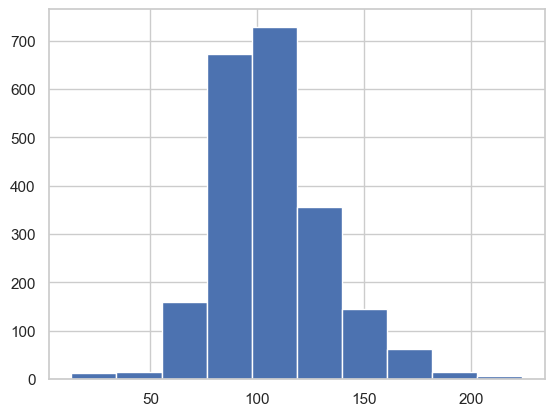

In [13]:
movies_df.runtime.hist();

We will use min max scaler to encode movie runtime.

In [14]:
movies_df.insert(value=MinMaxScaler().fit_transform(movies_df.runtime.values.reshape(-1,1)), column='runtime_normalized', loc=3)
movies_df = movies_df.drop(columns=['runtime'])
movies_df.head()

,movie_idx,label,title,runtime_normalized,age_certification_normalized,release_year,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
movie_id,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.478673,0.8,1976,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
154986,1,0.810811,Deliverance,0.454976,0.8,1972,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
127384,2,0.878378,Monty Python and the Holy Grail,0.369668,0.4,1975,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811
120801,3,0.810811,The Dirty Dozen,0.649289,0.6,1967,"['war', 'action']","['GB', 'US']",7.7,72662.0,20.398,7.600
70993,4,0.851351,Life of Brian,0.383886,0.8,1979,['comedy'],['GB'],8.0,395024.0,17.770,7.800


#### Movie Release Year

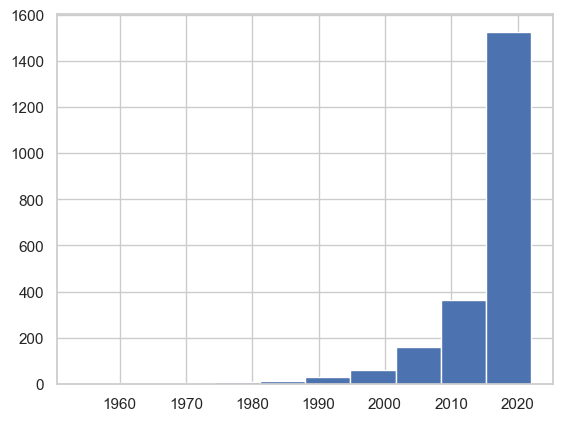

In [15]:
movies_df.release_year.hist();

For release year we will also use min max scaler. 

In [16]:
movies_df.insert(value=MinMaxScaler().fit_transform(movies_df.release_year.values.reshape(-1,1)), column='release_year_normalized', loc=3)
movies_df = movies_df.drop(columns=['release_year'])
movies_df.head()

,movie_idx,label,title,release_year_normalized,runtime_normalized,age_certification_normalized,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
movie_id,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.323529,0.478673,0.8,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179
154986,1,0.810811,Deliverance,0.264706,0.454976,0.8,"['drama', 'action', 'thriller', 'european']",['US'],7.7,107673.0,10.010,7.300
127384,2,0.878378,Monty Python and the Holy Grail,0.308824,0.369668,0.4,"['fantasy', 'action', 'comedy']",['GB'],8.2,534486.0,15.461,7.811
120801,3,0.810811,The Dirty Dozen,0.191176,0.649289,0.6,"['war', 'action']","['GB', 'US']",7.7,72662.0,20.398,7.600
70993,4,0.851351,Life of Brian,0.367647,0.383886,0.8,['comedy'],['GB'],8.0,395024.0,17.770,7.800


####  Movie Genres

In [17]:
movies_df.genres = movies_df.genres.apply(tools.string_to_array)
movies_df.head()

,movie_idx,label,title,release_year_normalized,runtime_normalized,age_certification_normalized,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
movie_id,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.323529,0.478673,0.8,"[drama, crime]",['US'],8.2,808582.0,40.965,8.179
154986,1,0.810811,Deliverance,0.264706,0.454976,0.8,"[drama, action, thriller, european]",['US'],7.7,107673.0,10.010,7.300
127384,2,0.878378,Monty Python and the Holy Grail,0.308824,0.369668,0.4,"[fantasy, action, comedy]",['GB'],8.2,534486.0,15.461,7.811
120801,3,0.810811,The Dirty Dozen,0.191176,0.649289,0.6,"[war, action]","['GB', 'US']",7.7,72662.0,20.398,7.600
70993,4,0.851351,Life of Brian,0.367647,0.383886,0.8,[comedy],['GB'],8.0,395024.0,17.770,7.800


In [18]:
mlb = MultiLabelBinarizer()
movies_df = movies_df.join(pd.DataFrame(mlb.fit_transform(movies_df.pop('genres')),
                          columns=mlb.classes_,
                          index=movies_df.index))
movies_df.head()

,movie_idx,label,title,release_year_normalized,runtime_normalized,age_certification_normalized,production_countries,imdb_score,imdb_votes,tmdb_popularity,...,history,horror,music,reality,romance,scifi,sport,thriller,war,western
movie_id,,,,,,,,,,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.323529,0.478673,0.8,['US'],8.2,808582.0,40.965,...,0,0,0,0,0,0,0,0,0,0
154986,1,0.810811,Deliverance,0.264706,0.454976,0.8,['US'],7.7,107673.0,10.010,...,0,0,0,0,0,0,0,1,0,0
127384,2,0.878378,Monty Python and the Holy Grail,0.308824,0.369668,0.4,['GB'],8.2,534486.0,15.461,...,0,0,0,0,0,0,0,0,0,0
120801,3,0.810811,The Dirty Dozen,0.191176,0.649289,0.6,"['GB', 'US']",7.7,72662.0,20.398,...,0,0,0,0,0,0,0,0,1,0
70993,4,0.851351,Life of Brian,0.367647,0.383886,0.8,['GB'],8.0,395024.0,17.770,...,0,0,0,0,0,0,0,0,0,0


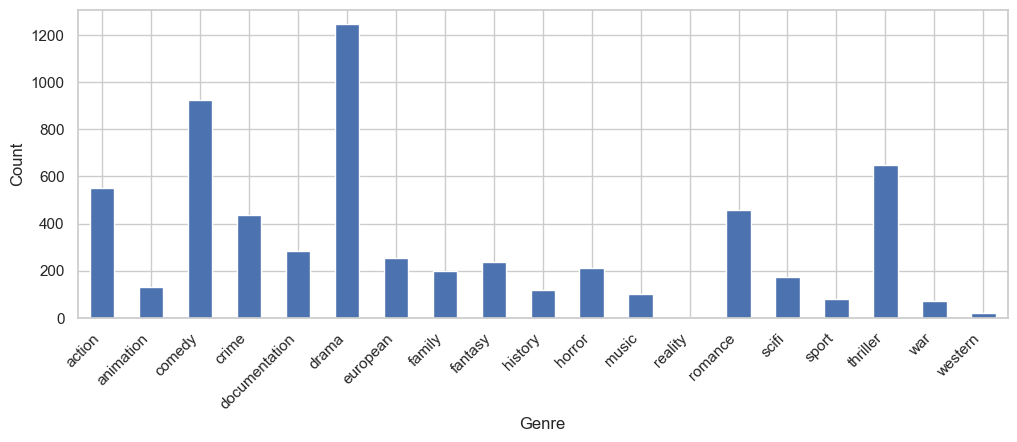

In [19]:
genre_counts = movies_df[mlb.classes_].sum()
genre_counts.plot(kind='bar', figsize=(12, 4))
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

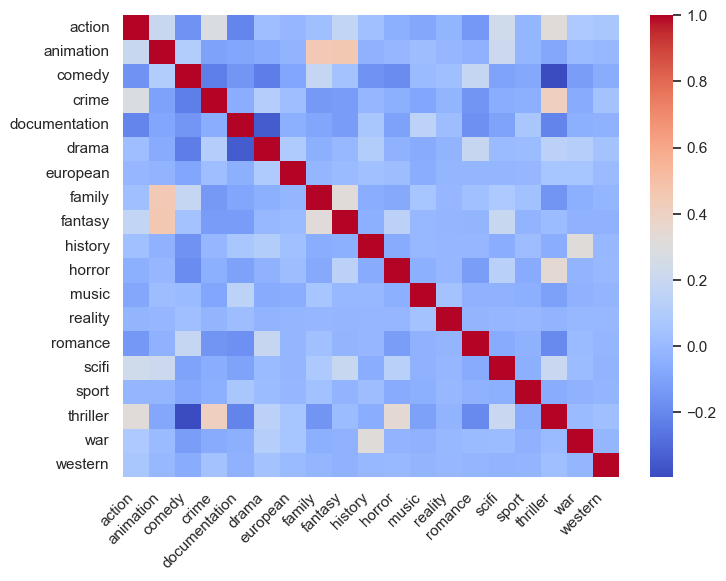

In [20]:
correlation_matrix = movies_df[list(mlb.classes_)].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.xticks(rotation=45, ha='right')
plt.show()

As we can see, most genres don't exhibit strong correlations with each other, but there are few that need to be highlighted
* Animation has a moderate correlation with family and fantasy genres.
* There is a slight correlation between crime and thriller genres.
* There is a negative correlation between thriller and comedy.

Next, lets plot correlation matrix between every feature and movie rating.

22


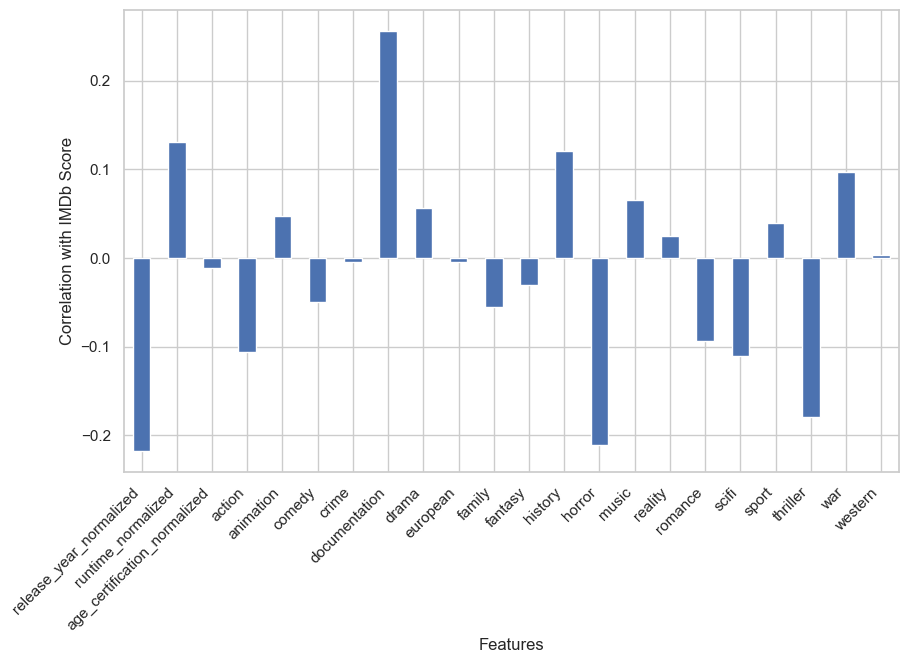

In [21]:
correlations = movies_df[['label', 'release_year_normalized', 'runtime_normalized', 'age_certification_normalized'] + list(mlb.classes_)].corr()['label'].drop('label')
print(len(correlations))
correlations.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with IMDb Score')
plt.grid(True)
plt.show()

As we can see, there is little strong correlation between most movie features and IMDb scores but we can notice that.
* Documentaries often receive higher ratings than other genres.
* Horror and thriller films tend to have lower ratings.
* Older movies generally achieve higher ratings compared to newer ones.

### Person Nodes
Let's extract every person in dataset and give it index to be used when constructing the graph edges. 

In [22]:
person_df = credits_filtered_df[['person_id', 'name']].drop_duplicates().reset_index(drop=True)

person_df = person_df.reset_index().set_index('person_id')
person_df = person_df.rename(columns={'index': 'person_idx'})
print(f"Person count {len(person_df)}")
person_df.head()

Person count 36734


,person_idx,name
person_id,,
3748,0,Robert De Niro
14658,1,Jodie Foster
7064,2,Albert Brooks
3739,3,Harvey Keitel
48933,4,Cybill Shepherd


Next, we calculate and assign edge weights to actors and directors based on their position in the cast using an exponential decay function. The decay coefficient is set to a value less than 1, meaning that actors or directors appearing earlier in the list (typically main characters) receive lower edge weights compared to those appearing later. This approach helps us prevent weight saturation where the most important nodes (main actors or directors) might dominate the learning process. By reducing the weight of main actors, we ensure that the model can also capture the contributions of supporting roles and other individuals lower in the cast hierarchy. In other words, allowing the GNN to learn effectively from both lead and non-lead roles.

In [23]:
def exponential_decay(x, alpha):
    return 1 / (alpha ** x)

DECAY = 1.3

credits_weighted_df = credits_filtered_df.copy()
credits_weighted_df['cast_order_index'] = credits_weighted_df.groupby(['movie_id', 'role']).cumcount()
credits_weighted_df['edge_weight'] = credits_weighted_df.groupby(['movie_id', 'role'])['cast_order_index'].transform(
    lambda x: exponential_decay(x, DECAY))

credits_weighted_df.head()

,label,person_id,movie_id,name,character,role,title,description,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,cast_order_index,edge_weight
0,0.878378,3748,84618,Robert De Niro,Travis Bickle,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179,0,1.000000
1,0.878378,14658,84618,Jodie Foster,Iris Steensma,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179,1,0.769231
2,0.878378,7064,84618,Albert Brooks,Tom,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179,2,0.591716
3,0.878378,3739,84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179,3,0.455166
4,0.878378,48933,84618,Cybill Shepherd,Betsy,ACTOR,Taxi Driver,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],8.2,808582.0,40.965,8.179,4,0.350128


As we can see for movie Taxi Driver Robert De Niro has the lowest weight. Let's check the directors as well before moving on.

In [24]:
credits_weighted_df[credits_weighted_df['role'] == 'DIRECTOR'][
    ['title', 'name', 'character', 'role', 'edge_weight']].head()

,title,name,character,role,edge_weight
36,Taxi Driver,Martin Scorsese,NaN,DIRECTOR,1.000000
59,Deliverance,John Boorman,NaN,DIRECTOR,1.000000
105,Monty Python and the Holy Grail,Terry Jones,NaN,DIRECTOR,1.000000
106,Monty Python and the Holy Grail,Terry Gilliam,NaN,DIRECTOR,0.769231
161,The Dirty Dozen,Robert Aldrich,NaN,DIRECTOR,1.000000


## Production Country Nodes

In [25]:
movies_df.production_countries = movies_df.production_countries.apply(tools.string_to_array)
movies_df.head()

,movie_idx,label,title,release_year_normalized,runtime_normalized,age_certification_normalized,production_countries,imdb_score,imdb_votes,tmdb_popularity,...,history,horror,music,reality,romance,scifi,sport,thriller,war,western
movie_id,,,,,,,,,,,,,,,,,,,,,
84618,0,0.878378,Taxi Driver,0.323529,0.478673,0.8,[US],8.2,808582.0,40.965,...,0,0,0,0,0,0,0,0,0,0
154986,1,0.810811,Deliverance,0.264706,0.454976,0.8,[US],7.7,107673.0,10.010,...,0,0,0,0,0,0,0,1,0,0
127384,2,0.878378,Monty Python and the Holy Grail,0.308824,0.369668,0.4,[GB],8.2,534486.0,15.461,...,0,0,0,0,0,0,0,0,0,0
120801,3,0.810811,The Dirty Dozen,0.191176,0.649289,0.6,"[GB, US]",7.7,72662.0,20.398,...,0,0,0,0,0,0,0,0,1,0
70993,4,0.851351,Life of Brian,0.367647,0.383886,0.8,[GB],8.0,395024.0,17.770,...,0,0,0,0,0,0,0,0,0,0


In [26]:
countries_df = list(set(chain.from_iterable(movies_df.production_countries)))
countries_df = pd.DataFrame(countries_df, columns=['country'])
countries_df = countries_df.reset_index()
countries_df = countries_df.rename(columns={'index': 'country_idx'})
countries_df = countries_df.set_index('country')
print(f"Countries count {len(countries_df)}")
countries_df.head()

Countries count 83


,country_idx
country,
PT,0
IE,1
BD,2
DK,3
BE,4


#### Production Country Edges

Now that we have everything ready lets convert them into indexes to be able to create graph.

In [27]:
edges_df = credits_weighted_df.merge(movies_df[['movie_idx']], left_on='movie_id', right_on='movie_id')
edges_df = edges_df.merge(person_df, left_on='person_id', right_on='person_id')
edges_df = edges_df[['person_idx', 'movie_idx','edge_weight', 'role']]
edges_df.head()

,person_idx,movie_idx,edge_weight,role
0,0,0,1.000000,ACTOR
1,1,0,0.769231,ACTOR
2,2,0,0.591716,ACTOR
3,3,0,0.455166,ACTOR
4,4,0,0.350128,ACTOR


In [28]:
country_edges_df = movies_df.explode('production_countries')
country_edges_df = country_edges_df.merge(countries_df, left_on='production_countries', right_on='country')
country_edges_df = country_edges_df[['movie_idx', 'country_idx']]
country_edge_index = torch.tensor(country_edges_df[['movie_idx', 'country_idx']].values).reshape(-1, 2).T.long()
country_edges_df.head()

,movie_idx,country_idx
0,0,44
1,1,44
2,2,65
3,3,65
4,3,44


In [29]:
country_edges_df['country_order_index'] = country_edges_df.groupby('movie_idx').cumcount()
country_edges_df['edge_weight'] = country_edges_df.groupby('movie_idx')['country_order_index'].transform(lambda x: exponential_decay(x, DECAY))
country_edges_df.head()

,movie_idx,country_idx,country_order_index,edge_weight
0,0,44,0,1.000000
1,1,44,0,1.000000
2,2,65,0,1.000000
3,3,65,0,1.000000
4,3,44,1,0.769231


## Graph Generation
The last step before generating a graph is to convert everything to tensor. 

In [30]:
actor_edge_index = tools.extract_person_edge_index_as_tensor(edges_df, 'ACTOR')
director_edge_index = tools.extract_person_edge_index_as_tensor(edges_df, 'DIRECTOR')
actor_edge_weight = torch.tensor(edges_df[edges_df['role'] == 'ACTOR']['edge_weight'].values, dtype=torch.float32)
director_edge_weight = torch.tensor(edges_df[edges_df['role'] == 'DIRECTOR']['edge_weight'].values, dtype=torch.float32)

country_edge_weight = torch.tensor(country_edges_df['edge_weight'].values, dtype=torch.float32)

print('actor edge index:     ', actor_edge_index.shape)
print('actor edge weight:    ', actor_edge_weight.shape)
print('director edge index:  ', director_edge_index.shape)
print('director edge weight: ', director_edge_weight.shape)
print('country edge index:   ', country_edge_index.shape)
print('country edge weight:  ', country_edge_weight.shape)
print('total edges: ', actor_edge_index.shape[1] + director_edge_index.shape[1] + country_edge_index.shape[1])

actor edge index:      torch.Size([2, 45778])
actor edge weight:     torch.Size([45778])
director edge index:   torch.Size([2, 2309])
director edge weight:  torch.Size([2309])
country edge index:    torch.Size([2, 2728])
country edge weight:   torch.Size([2728])
total edges:  50815


Finally, we construct a heterogeneous graph using HeteroData object.
* Movie Nodes
    * Movies are assigned feature vectors based on relevant attributes.
* Person Nodes
    * The feature vectors for people are initialized as zero vectors, as we have no specific attributes for them.
    * The relationships between people and movies (both actor and director) are represented with edge weights.
* Country Nodes
    * Similar to person nodes, the feature vectors for countries are initialized as zero vectors.
    * The relationships are defined based on where the movie was produced, with corresponding edge weights.
we convert the graph into an undirected format, allowing bidirectional flow of information during training.

Total number of nodes: 38986
Total number of movie nodes: 2169
Total number of bidirectional edges: 50815


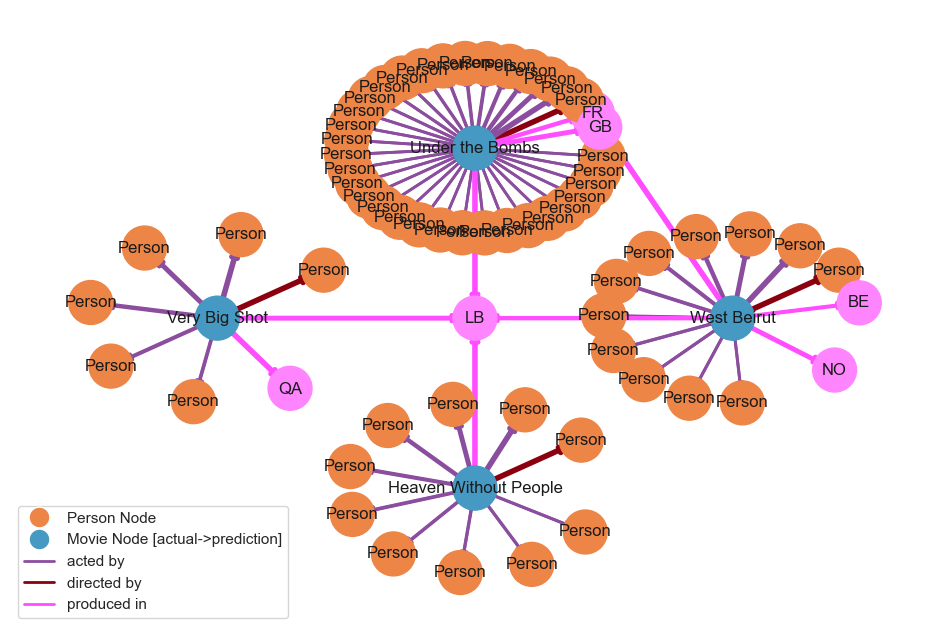

In [31]:
data_unidirectional = HeteroData()

data_unidirectional['movie'].x = torch.tensor(movies_df[['age_certification_normalized', 'release_year_normalized', 'runtime_normalized'] + list(mlb.classes_)].values).float()
data_unidirectional['movie'].label = movies_df.title.values
data_unidirectional['movie'].y = torch.tensor(movies_df.label.values).float()
data_unidirectional['person'].x = torch.zeros(len(person_df), 2).float()
data_unidirectional['person'].label = person_df.name.values

data_unidirectional['movie', 'directed_by', 'person'].edge_index = director_edge_index
data_unidirectional['movie', 'acted_by', 'person'].edge_index = actor_edge_index

data_unidirectional['movie', 'acted_by', 'person'].edge_weight = actor_edge_weight
data_unidirectional['movie', 'directed_by', 'person'].edge_weight = director_edge_weight


data_unidirectional['country'].x = torch.zeros(len(countries_df), 1).float()
data_unidirectional['country'].label = countries_df.index.values
data_unidirectional['movie', 'produced_in', 'country'].edge_index = country_edge_index
data_unidirectional['movie', 'produced_in', 'country'].edge_weight = country_edge_weight

data = T.ToUndirected()(data_unidirectional)

tools.draw_country_graph('LB', data ,data_unidirectional)
total_nodes = sum(data_unidirectional[node_type].num_nodes for node_type in data_unidirectional.node_types)
print(f"Total number of nodes: {total_nodes}")
print(f"Total number of movie nodes: {data_unidirectional['movie'].num_nodes}")
total_edges = sum(data_unidirectional[edge_type].num_edges for edge_type in data_unidirectional.edge_types)
print(f"Total number of bidirectional edges: {total_edges}")

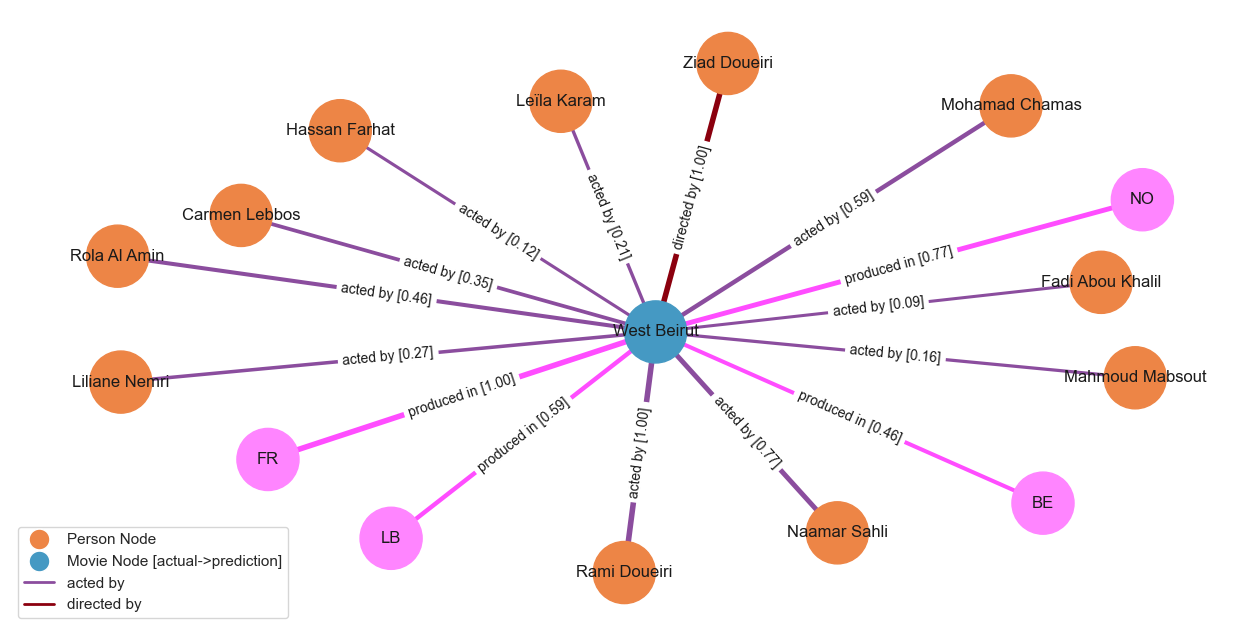

In [32]:
tools.draw_graph(data_unidirectional, 'West Beirut')

In [33]:
countries_df

,country_idx
country,
PT,0
IE,1
BD,2
DK,3
BE,4
...,...
PR,78
GH,79
LU,80


## Train Test split

We use the `train_rest` approach to split the data, where all nodes not assigned to the validation or test sets are used for training. This method, inspired by the FastGCN paper Fast Learning with Graph Convolutional Networks via Importance Sampling, ensures that the model is trained on the maximum number of nodes, while still setting aside dedicated validation and test sets to evaluate performance. In our case, 10% of the nodes are reserved for validation and 20% for testing, leaving the remaining 70% of the nodes for training.

In [34]:
transform = T.RandomNodeSplit(num_val=0.1, num_test=0.2, split='train_rest')
data = transform(data)

Next, let's define helper functions to predict movie ratings and calculate the mean squared error (MSE).

In [35]:
@torch.no_grad()
def predict(model, data):
    model.eval()
    return model(data.x_dict, data.edge_index_dict, data.edge_weight_dict)['movie'].squeeze()

@torch.no_grad()
def calculate_loss(model, mask, data):
    mse_loss = MSELoss()
    acc = mse_loss(predict(model, data)[mask], data['movie'].y[mask])
    return acc

## Dummy Model
Before moving on to model training, let's first create a `dummy model` that predicts the mean movie rating for all movies, serving as a baseline for comparison. 

In [36]:
class Dummy(torch.nn.Module):
    def __init__(self, mean):
        super().__init__()
        self.mean = mean

    def forward(self, x_dict, _, __):
        return torch.full_like(x_dict[:, :1], self.mean)

mean_rating = movies_df.label.describe()['mean']
dummy_model = Dummy(mean_rating)
dummy_model = to_hetero(dummy_model, data.metadata(), aggr='mean')
predict(dummy_model, data)
dummy_model_test_acc = calculate_loss(dummy_model, data['movie'].test_mask, data)

mean_rating_scaled = rating_scaler.inverse_transform([[mean_rating]])
print(f'Mean IMDb rating: {mean_rating_scaled[0][0]:.5f}')
print(f'Dummy model test Loss: {dummy_model_test_acc:.5f}')
mae = mean_absolute_error(movies_df['label'], len(movies_df) * [mean_rating])
r2 = r2_score(movies_df['label'], len(movies_df) * [mean_rating])
print(f'Test MAE: {mae:.5f}')
print(f'Test R-squared: {r2:.5f}')

Mean IMDb rating: 6.40553
Dummy model test Loss: 0.01987
Test MAE: 0.11352
Test R-squared: 0.00000


# Training
We construct a GNN using PyTorch Geometric's GraphConv layers. Given the heterogeneous nature of the graph, with varying node types and features, we implement dynamic input initialization (-1, -1) in the first layer to enable automatic inference of input dimensions during runtime. A Leaky ReLU activation function is applied between the layers, and the hidden features are ultimately reduced to a single scalar output, corresponding to the predicted rating for each movie.

Dummy model Loss:  0.01987
Test GraphGAT Loss: 0.01565


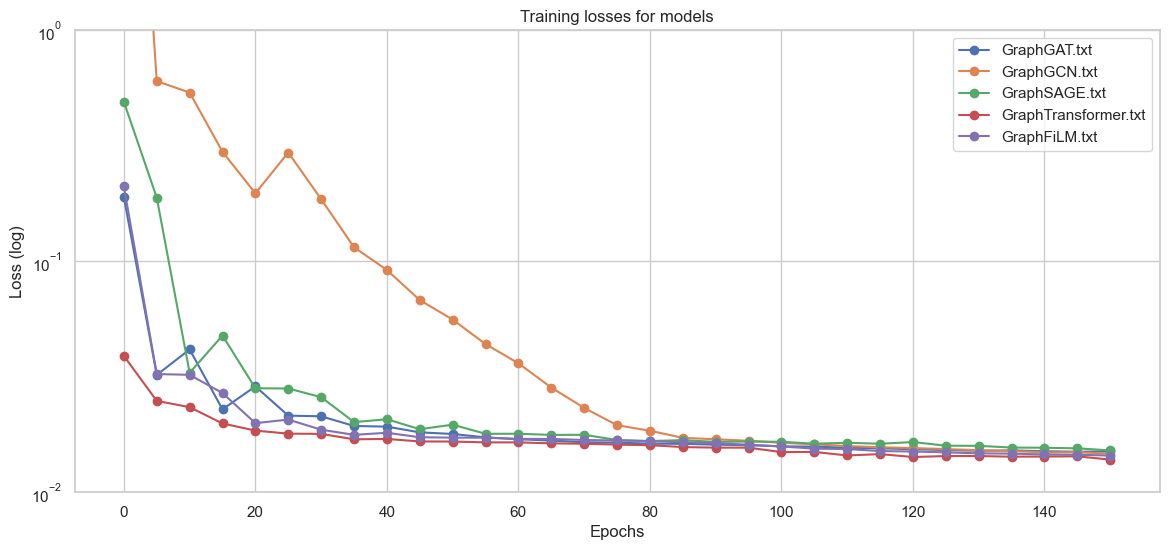

In [37]:
epochs = []
def train_model(model, model_name, data, num_epochs):
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
    loss_function = L1Loss()
    for epoch in range(num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict, edge_weight_dict=data.edge_weight_dict)
        mask = data['movie'].train_mask
        loss = loss_function(out['movie'].squeeze()[mask], data['movie'].y[mask])
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            train_acc = calculate_loss(model, data['movie'].train_mask, data)
            val_acc = calculate_loss(model, data['movie'].val_mask, data)
            epochs.append((train_acc, val_acc))
    test_acc = calculate_loss(model, data['movie'].test_mask, data)
    print(f'Dummy model Loss:  {dummy_model_test_acc:.5f}')
    print(f'Test {model_name} Loss: {test_acc:.5f}')
    tools.save_model_losses(epochs, model_name)
    tools.plot_train_validation_loss_graph()

# possible models are: GraphGCN, GraphSAGE, GraphGAT, GraphFiLM, GraphTransformer
graph_model = models.GraphGAT(dim_h=4)
graph_model_name = graph_model.__class__.__name__
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graph_model = graph_model.to(device)
graph_model = to_hetero(graph_model, data.metadata(), aggr='mean')
train_model(graph_model, graph_model_name, data, num_epochs=150)

# Evaluation
Now, that we have our model trained lets predict the movie ratings in test split and go over some case studies

In [38]:
predictions = predict(graph_model, data)
predictions_full_df = movies_df.copy()
predictions_full_df.insert(value=predictions, column='predictions', loc=2)
score_predictions = rating_scaler.inverse_transform(predictions_full_df[['predictions']])
predictions_full_df.insert(value=score_predictions, column='predicted_score', loc=9)
predictions_full_df.insert(value=abs(predictions_full_df.imdb_score - predictions_full_df.predicted_score), column='residual', loc=1)
predictions_df = predictions_full_df[data['movie'].test_mask.squeeze().numpy()]
predictions_df.head()

,movie_idx,residual,label,predictions,title,release_year_normalized,runtime_normalized,age_certification_normalized,production_countries,imdb_score,...,history,horror,music,reality,romance,scifi,sport,thriller,war,western
movie_id,,,,,,,,,,,,,,,,,,,,,
70993,4,1.103903,0.851351,0.702175,Life of Brian,0.367647,0.383886,0.8,[GB],8.0,...,0,0,0,0,0,0,0,0,0,0
16479,11,0.902068,0.783784,0.661883,White Christmas,0.000000,0.483412,0.6,[US],7.5,...,0,0,0,0,1,0,0,0,0,0
89386,13,0.537361,0.783784,0.856400,Hitler: A Career,0.338235,0.649289,0.4,[DE],7.5,...,1,0,0,0,0,0,0,0,0,0
27298,16,0.305896,0.797297,0.838635,Saladin the Victorious,0.132353,0.819905,0.6,[EG],7.6,...,1,0,0,0,1,0,0,0,1,0
155787,18,1.304502,0.945946,0.769662,GoodFellas,0.529412,0.625592,0.8,[US],8.7,...,0,0,0,0,0,0,0,0,0,0


Let’s also calculate the Mean Absolute Error (MAE) and R-squared (R²) score to get a quantitative measure of our model's performance.

In [39]:
mae = mean_absolute_error(predictions_df['label'], predictions_df['predictions'])
r2 = r2_score(predictions_df['label'], predictions_df['predictions'])
print(f'Test MAE: {mae:.5f}')
print(f'Test R-squared: {r2:.5f}')

Test MAE: 0.09250
Test R-squared: 0.21199


The MAE of 0.09299 suggests that the model's predictions are close to the actual ratings. However, the R² score of 0.16467 indicates that the model explains only 16.5% of the variance in the ratings, showing that while the predictions are fairly accurate, the model isn't fully capturing the complexity of the data and can be improved. 

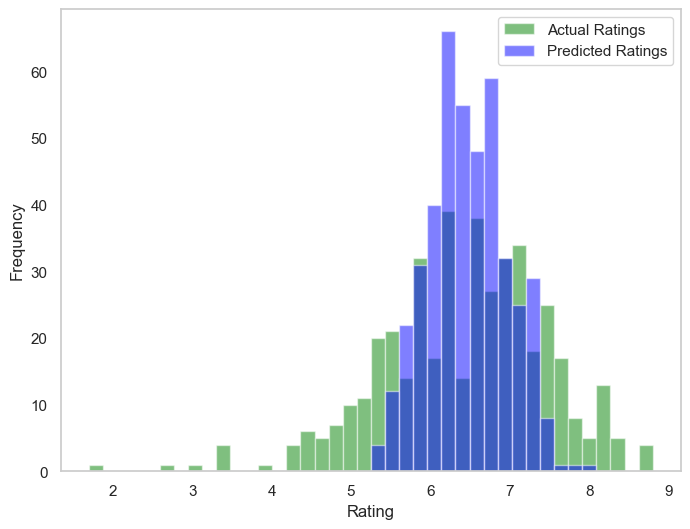

In [40]:
plt.figure(figsize=(8, 6))
bin_edges = np.histogram_bin_edges(predictions_df['imdb_score'], bins=40)
predictions_df['imdb_score'].hist(alpha=0.5, label='Actual Ratings', color='green', bins=bin_edges)
predictions_df['predicted_score'].hist(alpha=0.5, label='Predicted Ratings', color='blue',bins=bin_edges)
plt.grid(False)
plt.axis('on')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

As we can see the spread of actual ratings is broader, with more variance, especially in the lower and higher rating ranges. This indicates that while the model is able to predict the central tendency fairly accurately, it struggles to capture the full distribution of the ratings, particularly for movies with very low or very high ratings. This further supports the relatively low R² score, highlighting the model's difficulty in explaining the variability in movie ratings.
Next, let's plot box graph for residuals as well 

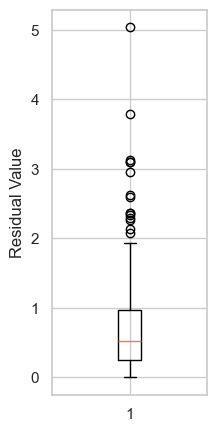

In [41]:
residuals = predictions_df['residual']
plt.figure(figsize=(2, 5))
plt.boxplot(residuals)
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

Here, we can see that most residuals are tightly clustered around 0, indicating that the model's predictions are fairly close to the actual ratings for the majority of movies. However, the presence of several outliers extending up to 0.7 shows that there are cases where the model significantly underperforms, again reinforcing the idea that while the model performs well for the central distribution of ratings, it struggles with edge cases.

# Case studies
First let's check the worst 5 predicted movies and plot the graph for the one.

,title,imdb_score,predicted_score,residual
movie_id,,,,
171891,Himmatwala,1.7,6.736632,5.036632
976632,Indoo Ki Jawani,3.0,6.784199,3.784199
832345,365 Days,3.3,6.434273,3.134273
933375,Cuties,3.4,6.503860,3.103860
154375,Main Aurr Mrs Khanna,3.4,6.494437,3.094437


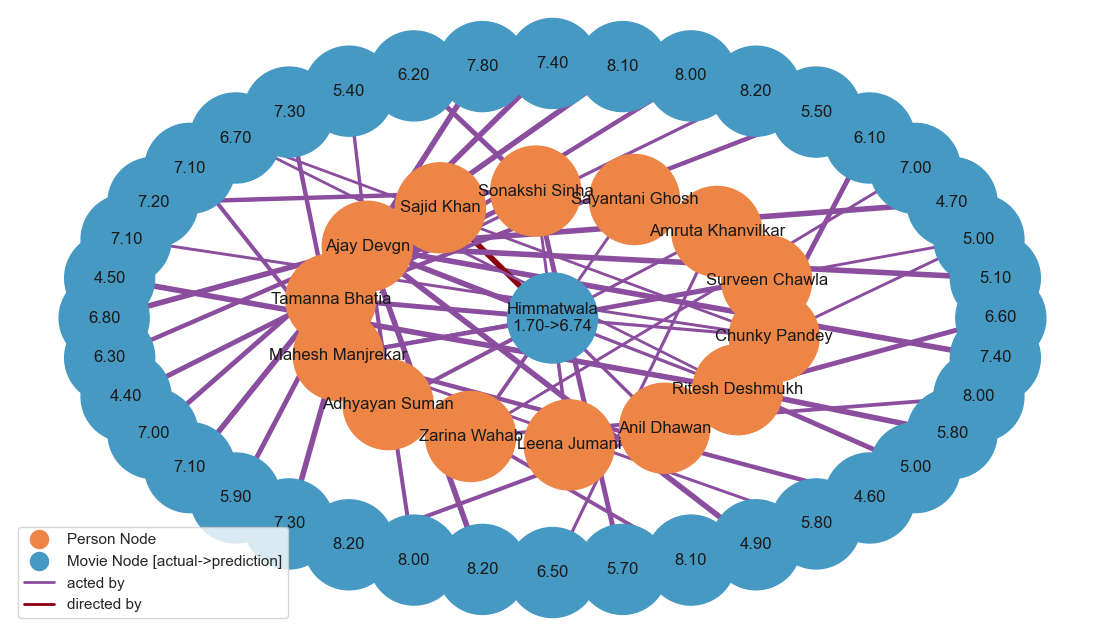

In [42]:
worst_predicted_movie_title = predictions_df.sort_values('residual', ascending=False)['title'].values[0]
tools.draw_graph_with_2_radius_excluding_countries(data_unidirectional, worst_predicted_movie_title, '', predictions_df=predictions_full_df)
predictions_df.sort_values('residual', ascending=False)[['title','imdb_score','predicted_score','residual']].head()

Next, let's check the best predicted movies.

,title,imdb_score,predicted_score,residual
movie_id,,,,
19494,The Replacements,6.6,6.599829,0.000171
1226954,Girl in the Picture,7.3,7.300857,0.000857
514494,Offering to the Storm,6.2,6.202832,0.002832
918853,All Together Now,6.5,6.497111,0.002889
319818,Outlaw King,6.9,6.894284,0.005716


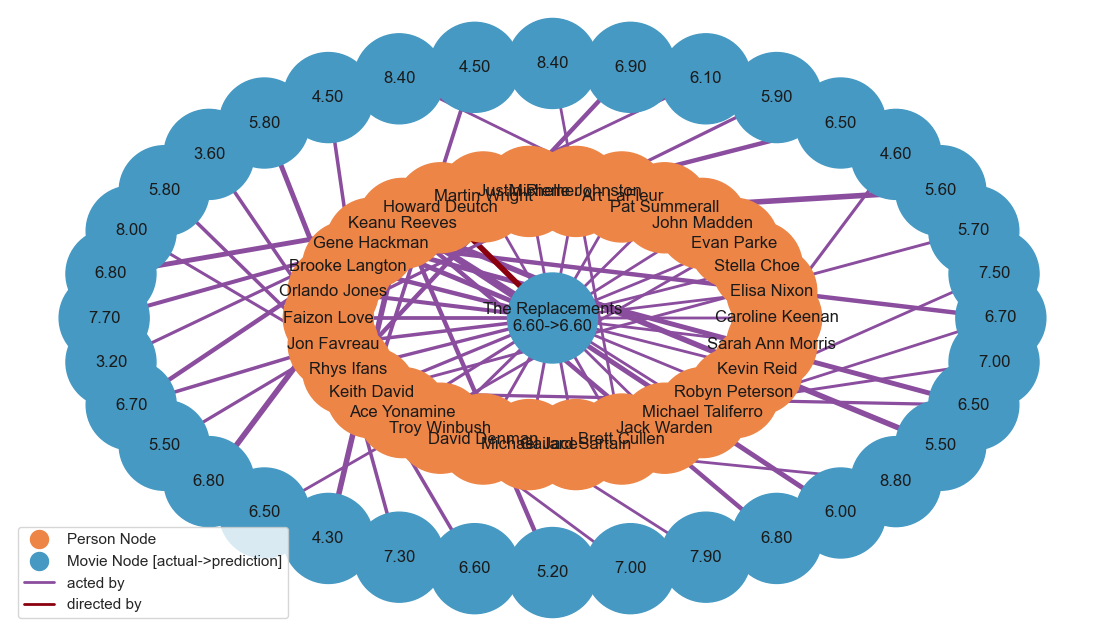

In [43]:
best_predicted_movie_title = predictions_df.sort_values('residual', ascending=True)['title'].values[0]
tools.draw_graph_with_2_radius_excluding_countries(data_unidirectional, best_predicted_movie_title, '', predictions_df=predictions_full_df)
predictions_df.sort_values('residual', ascending=True)[['title','imdb_score','predicted_score','residual']].head(5)

Now, lets see how good Tom Cruise movies were predicted by our model.

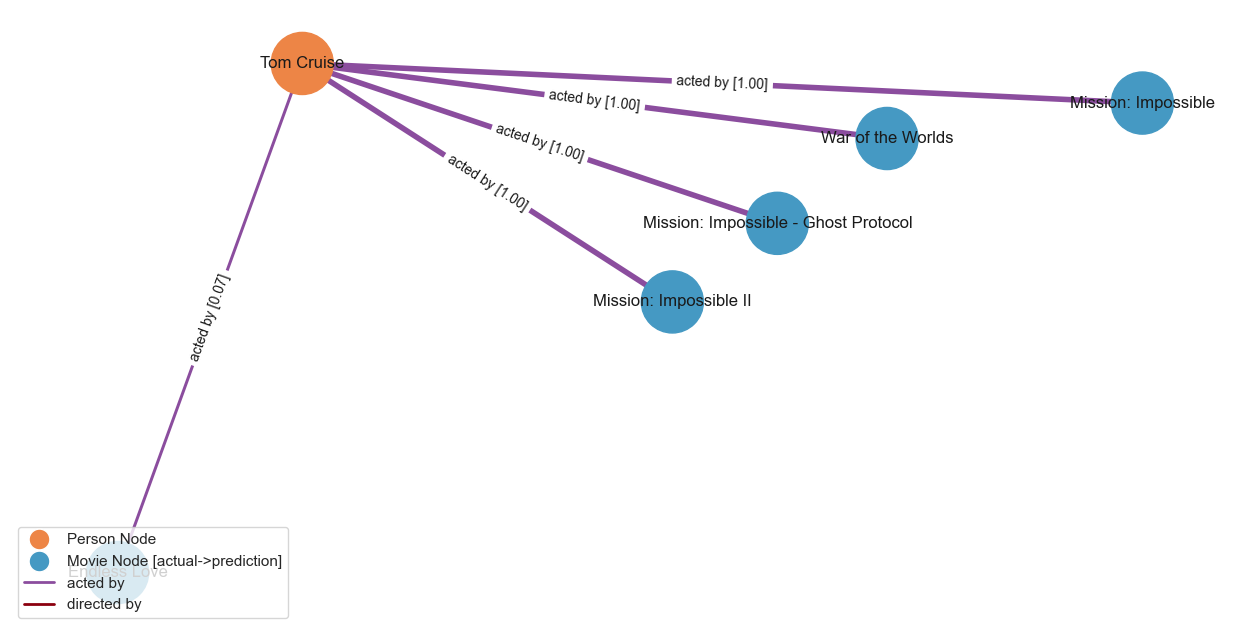

In [44]:
tools.draw_graph(data_unidirectional, 'Tom Cruise', '')

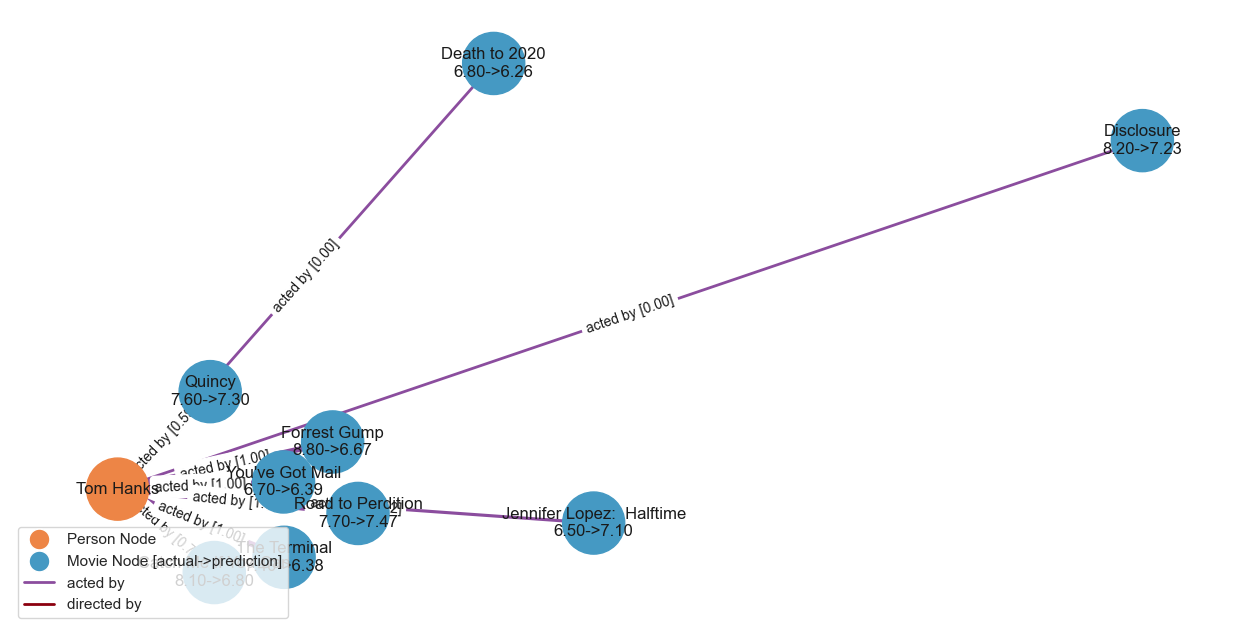

In [45]:
tools.draw_graph(data_unidirectional, 'Tom Hanks', '', predictions_df=predictions_full_df)

# Conclusion
In this research, we applied GNN to predict movie ratings based on a heterogeneous graph structure. By modeling relationships between movies, actors, directors, and production countries, we demonstrated the potential of GNNs in extracting meaningful patterns from relational data. The use of edge weights based on cast order, along with few movie node attributes, allowed us to predict the movie rating without having any information on movie plot or budget.

The results, measured by metrics such as Mean Absolute Error (MAE) and R² score, showed that while the model was able to make reasonable predictions for the central distribution of movie ratings, it struggled to capture the full variance of the dataset, especially in edge cases. This suggests that while GNNs are effective for learning from graph-based data, there remains room for improvement, particularly in capturing more complex patterns and relationships within the graph.

### Future work
For future work, optimizing the model by incorporating additional node and edge features, refining the graph structure, or experimenting with more advanced GNN architectures could further improve the model's predictive accuracy. Additionally, exploring different ways to handle outliers and extreme cases in the dataset would provide better generalization and overall performance.
* Add movie genres as edge attributes: Introduce movie genres as edge attributes, as certain actors may excel in specific genres (e.g., comedy) but perform less effectively in others (e.g., drama). This could enhance the model's understanding of actor performance across different genres.
* Add edges between movies for sequels or prequels: Create direct edges between movies that are part of a series, such as sequels and prequels. This will allow the model to capture relationships between related films, which may influence a movie’s rating based on the success or failure of its predecessors or successors.
* todo